In [35]:
import random,copy,math,time,os,csv,sys

from importlib import reload

import pandas as pd
import thermodynamic_model as tfe # this is the module I wrote 

# numpy/scipy stuff
import numpy as np
from scipy import optimize  # used for fitting
from scipy import stats

# plotting stuff
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
import matplotlib.gridspec as gridspec

from matplotlib import rc
FONT_SIZE = 20
rc('font',**{'family':'serif','serif':['CMU Serif']})
rc('axes', titlesize=FONT_SIZE,labelsize=FONT_SIZE)  
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=15) 
mpl.rcParams['font.size'] = 12
rc('text', usetex=True)

%matplotlib inline

# Energy distribution for random sites

Text(0.5, 0, 'Position')

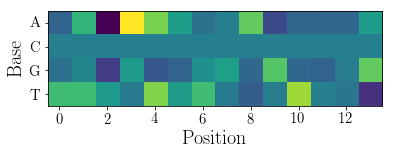

In [36]:
L = 14
# generate energy matrix
# units are in kbT
E = np.random.normal(0.15,0.1,(L,4)) 
E[:,1] = 0.1*np.ones(L)
site = np.random.choice(range(4),L)
A = np.zeros((4,L))
plt.imshow(E.T)

# plotting stuff
ax = plt.gca()
plt.yticks(np.arange(4), ('A','C','G','T'))
ax.set_ylabel('Base')
ax.set_xlabel('Position')

In [37]:
g_set = [np.random.choice(range(4),L) for k in range(10000)]
E_rand = []
for g in g_set:
    E_sum= np.sum([E[k,g[k]] for k in range(L)])
    E_rand.append(E_sum)

Text(0.5, 0, '$E$')

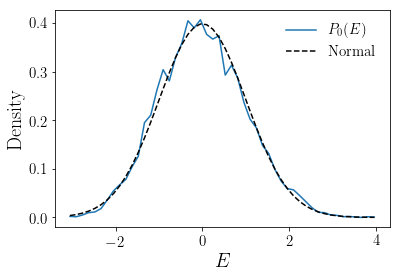

In [38]:
# plot histogram of normalized energy
hist,bins= np.histogram((E_rand-np.mean(E_rand))/np.std(E_rand),50,density=True);
bins = (bins[1:]+bins[:-1])/2
plt.plot(bins,hist,'-',label='$P_0(E)$')

# compare to Guassian
plt.plot(bins,1/np.sqrt(2*np.pi)*np.exp(-bins**2/2),'k--',label='Normal')

# plotting stuff
plt.legend(loc='upper right',frameon=False)
ax = plt.gca()
ax.set_ylabel('Density')
ax.set_xlabel('$E$')

# Energy distribution of site under selection

## Build thermodynamic model using tf_thermodynamic_model class

In [39]:
# I've written a class for working with thermodynamic models of tf evolution. 
# In order to define a model, we need the following paramaters
L = 14 # number of base pairs in each site          
M_sites = 1 # number of binding sites
M_factors = 1 # number of transcription factors
binding_energies = [E] # binding energy matrices for each tf (a list of M_factors L x 4 arrays)
#binding_energies[0][:,0]= np.ones(L)
interaction_energies = np.array([[0.0]]) # no protien-protien interactions in this mode so don't worry about this 
rates = np.zeros((M_sites,M_factors))  # transcription rates
rates[0,0]= 1.
tf_concentrations = np.array([1.]) # tf concentrations

In [40]:
reload(tfe)
model = tfe.tf_thermodynamic_model(binding_energies,interaction_energies,rates,tf_concentrations,M_sites)
sel= 0.05 # strength of selection on gene expression at site
def fitness_func(model,g): # use expression level as proxy for fitness
    return sel*model.expression_level(g)

In [41]:
g0 = np.array([np.random.choice(range(4),L) for k in range(M_sites)])
print(g0)
fitness_func(model,g0)

[[0 2 1 0 3 2 1 2 2 1 0 3 3 0]]


0.007489394591600255

## Look at the fitness landscape of random sites

In [42]:
g_set = [np.array([np.random.choice(range(3),L)]*M_sites) for k in range(50)]
f_set = [fitness_func(model,g) for g in g_set]
E_set = [np.sum([binding_energies[0][k,g[0][k]] for k in range(L)]) for g in g_set]

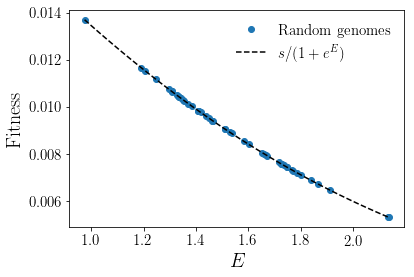

In [43]:
plt.plot(E_set,f_set,'o',label='Random genomes')
x = np.linspace(np.min(E_set),np.max(E_set),100)
plt.plot(x,sel/(1+np.exp(x)),'k--',label=r'$s/(1+e^E)$')
ax = plt.gca()
ax.set_xlabel(r'$E$')
ax.set_ylabel('Fitness')
plt.legend(loc='upper right',frameon=False)

## Run stochastic simulations in SSWM regime

In [ ]:
ne = 1000
tmax = 500
t,g = model.substitution_evolution(tmax,g0,fitness_func,0.2,ne)

In [ ]:
f_path = [fitness_func(model,gt.reshape((M_sites,L))) for gt in g ]
E_path = [np.sum([E[k,gt.reshape((M_sites,L))[0,k]] for k in range(L)]) for gt in g ]

In [ ]:
plt.semilogy(t,f_path,'-',alpha=0.9)
ax = plt.gca()
ax.set_xlabel('Time')
ax.set_ylabel('Fitness')

In [ ]:
plt.semilogy(t,E_path,'-',alpha=0.9)
ax = plt.gca()
ax.set_xlabel('Time')
ax.set_ylabel('Energy')

## Compare inferred fitness landscape to analytical formula

In [ ]:
E_stat = E_path[200:] # get the stationary distribution by ignoring the initial transient 
E_all= E_stat+E_rand
bins = np.linspace(np.min(E_rand),np.max(E_all),40)
hist,x= np.histogram(E_stat,bins,density=True);
hist_rand,x= np.histogram(E_rand,bins,density=True);
x = (bins[1:]+bins[:-1])/2

In [ ]:
plt.plot(x,hist_rand,label='Random')
plt.semilogy(x,hist,'--',label='Functional')
ax = plt.gca()
ax.set_xlabel(r'$E$')
ax.set_ylabel('Density')
plt.legend(loc='upper right',frameon=False)

In [ ]:
const = np.log(hist[3]/hist_rand[3]) - 2*sel*ne/(1+np.exp(x[3]))
plt.plot(x,np.log(hist/hist_rand)-const,'o',label =r'$\ln(Q_f(E)/P_0(E))+{\rm const.}$')
plt.semilogy(x,2*sel*ne/(1+np.exp(x)),'k--',label =r'$2F(E)N_e$')
ax = plt.gca()
ax.set_xlabel('E')
plt.legend(loc='lower left',frameon=False)